# Visualizing The Raw FFT Computations

From our data pipeline, each raw SEEG/ECoG dataset will compute FFT and Morlet transformations with some specified window size and step size. 

It would be nice to visualize the distributions and heatmaps of the datasets computed to ensure that the scale and variance are confined.

In [1]:
import os
import numpy as np
import sys
sys.path.append('../../')
import sklearn

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

expname = 'visualize_fft'
figpath = os.path.join('/Users/adam2392/Documents/figures/', expname)
if not os.path.exists(figpath):
    os.makedirs(figpath)

# import statistical distance measures
from sklearn.preprocessing import scale
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
# from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import chisquare
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

%load_ext autoreload
%autoreload 2

In [2]:
def subset_labels(chanlabels1, chanlabels2):
    chanlabels1 = [label.lower() for label in chanlabels1]
    chanlabels2 = [label.lower() for label in chanlabels2]
    
    set1inds = []
    for label in chanlabels2:
        try:
            set1inds.append(chanlabels1.index(label))
        except ValueError as e:
            continue
#             print(e)

    chanlabels1 = np.array(chanlabels1)[set1inds]
    set2inds = []
    for label in chanlabels1:
        try:
            set2inds.append(chanlabels2.index(label))
        except ValueError as e:
            continue
#             print(e)
    chanlabels2 = np.array(chanlabels2)[set2inds]
    return set1inds, set2inds

def converttimestowindow(timepoints, time):
    winindices = np.where(np.logical_and(
        timepoints[:, 0] < time, timepoints[:, 1] > time))[0][0]
    return winindices

def sync_data(realdata, simdata, typedata='all'):
    # match up data based on the channel labels
    metadata = realdata['metadata'].item()
    realchanlabels = metadata['chanlabels']
    real_onsetind = metadata['onsetind'].astype(int)
    real_offsetind = metadata['offsetind'].astype(int)
    real_timepoints = realdata['timepoints']
    
    metadata = simdata['metadata'].item()
    chanlabels = metadata['chanlabels']
    sim_onsets = metadata['onsettimes']
    sim_offsets = metadata['offsettimes']
    sim_timepoints = simdata['timepoints']
    
    numsamps = len(sim_timepoints)
    iiwins = get_interictal(sim_onsets, sim_offsets, numsamps)
    
    set1, set2 = subset_labels(realchanlabels, chanlabels)
    
    real_onsetind = converttimestowindow(real_timepoints, real_onsetind)
    real_offsetind = converttimestowindow(real_timepoints, real_offsetind)
    sim_onsetind = converttimestowindow(sim_timepoints, sim_onsets[0])
    sim_offsetind = converttimestowindow(sim_timepoints, sim_offsets[0])
    
    # get the power spectrum at the mutual set of channels
    realpower = realdata['power'][set1, ...]
    simpower = simdata['power'][set2, ...]
    
    print(real_onsetind, real_offsetind)
    print(sim_onsetind, sim_offsetind)
    
    if typedata == 'ictal':
        realpower = clip_interictal(realpower, real_onsetind, real_offsetind)
        simpower = clip_interictal(simpower, sim_onsetind, sim_offsetind)
    elif typedata == 'interictal':
        realpower = clip_ictal(realpower, real_onsetind)
#         simpower = clip_ictal(simpower, sim_onsetind)
        simpower = simpower[...,iiwins]
    
    return realpower, simpower

def clip_ictal(power, onsetind):
    return power[..., 0:onsetind]

def clip_interictal(power, onsetind, offsetind):
    return power[..., onsetind:offsetind]

In [3]:
def get_interictal(onsets, offsets, numsamps):
    allwins = np.arange(0, numsamps).astype(int)
    print(onsets, offsets)
    print(allwins.shape)
    for idx, onset in enumerate(onsets):
        if idx < len(offsets):
            offset = offsets[idx]
            allwins[int(onset):int(offset)] = -1
        
    allwins[allwins==-1] = []
    print(allwins.shape)
    return allwins

# Load in Real SEEG FFT Data

In [4]:
patient = 'id001_bt'
# patient = ''

In [5]:
realseeg_fftdir = '/Volumes/ADAM LI/pydata/output_fft/tngcenter/fft/'
patdir = os.path.join(realseeg_fftdir, patient)

# get a list of all the datasets for this patient
filepaths = []
for root, dirs, files in os.walk(patdir):
    for file in files:
        if '.npz' in file:
            filepaths.append(os.path.join(root, file))
print(filepaths)


['/Volumes/ADAM LI/pydata/output_fft/tngcenter/fft/id001_bt/BTcrisePavecGeneralisation_0007_fftmodel.npz', '/Volumes/ADAM LI/pydata/output_fft/tngcenter/fft/id001_bt/BTcrise2appportable_0013_fftmodel.npz', '/Volumes/ADAM LI/pydata/output_fft/tngcenter/fft/id001_bt/BTcrise1appportable_0006_fftmodel.npz', '/Volumes/ADAM LI/pydata/output_fft/tngcenter/fft/id001_bt/BTcrisepartielle+preictalspiking_0009_fftmodel.npz']


In [6]:
for resultfile in filepaths:
    realdata = np.load(resultfile, encoding='latin1')
    power = realdata['power']
    freqs = realdata['freqs']
    metadata = realdata['metadata'].item()
    timepoints = realdata['timepoints']
    onsetind = metadata['onsetind']
    offsetind = metadata['offsetind']
    realchanlabels = metadata['chanlabels']

    print(realdata.keys())
    print(metadata.keys())
    print(power.shape)
    print(metadata['samplefreq'])
    break

['phase', 'timepoints', 'freqs', 'power', 'metadata']
dict_keys(['offsetsec', 'samplefreq', 'onsetind', 'onsetsec', 'offsetind', 'stepsize', 'winsize', 'mtbandwidth', 'rawfilename', 'chanlabels'])
(92, 2561, 298)
1024.0


# Load in Simulated SEEG FFT Data

In [7]:
simseeg_fftdir = '/Volumes/ADAM LI/pydata/output_sim/tvbsim/exp014/freq/fft/'
patdir = os.path.join(simseeg_fftdir, patient)

# get a list of all the datasets for this patient
filepaths = []
for root, dirs, files in os.walk(patdir):
    for file in files:
        if '.npz' in file:
            filepaths.append(os.path.join(root, file))
print(filepaths)


['/Volumes/ADAM LI/pydata/output_sim/tvbsim/exp014/freq/fft/id001_bt/id001_bt_dist-1_fftmodel.npz']


In [8]:
for resultfile in filepaths:
    simdata = np.load(resultfile, encoding='latin1')
    metadata = simdata['metadata'].item()
    power = simdata['power']
    freqs = simdata['freqs']
    timepoints = simdata['timepoints']
    onsetind = metadata['onsettimes']
    offsetind = metadata['offsettimes']
    chanlabels = metadata['chanlabels']

    print(simdata.keys())
    print(metadata.keys())
    print(power.shape)
    print(onsetind, offsetind)
    print(metadata['samplerate'])
    break

['phase', 'timepoints', 'freqs', 'power', 'metadata']
dict_keys(['ezregs', 'samplefreq', 'x0pz', 'epiparams', 'pzindices', 'patient', 'samplerate', 'ezindices', 'chanlabels', 'regions', 'offsettimes', 'onsettimes', 'gainmat', 'x0norm', 'stepsize', 'x0ez', 'pzregs', 'seeg_xyz', 'regions_centers', 'winsize', 'mtbandwidth', 'rawfilename'])
(161, 2501, 15)
[2664.0, 29311.0] [14146.0]
1000


In [9]:
realpower, simpower = sync_data(realdata, simdata)

realpower = np.abs(realpower)
simpower = np.abs(simpower)

print(realpower.shape)
print(simpower.shape)

[2664.0, 29311.0] [14146.0]
(15,)
(15,)
85 200
0 4
(92, 2561, 298)
(92, 2501, 15)


# Plot Real Vs Sim Power Spectrum Distribution

[2664.0, 29311.0] [14146.0]
(15,)
(15,)
85 200
0 4
(92, 2561, 85)
(92, 2501, 15)
[2664.0, 29311.0] [14146.0]
(15,)
(15,)
85 200
0 4
(92, 2561, 115)
(92, 2501, 4)


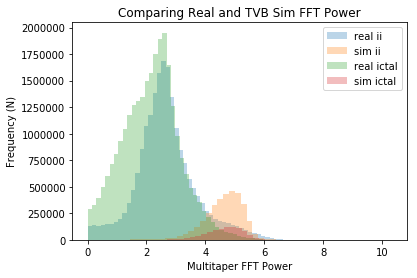

In [10]:
realpower, simpower = sync_data(realdata, simdata, 'interictal')

realpower = np.abs(realpower)
simpower = np.abs(simpower)

print(realpower.shape)
print(simpower.shape)

plt.figure() # hist_kws=dict(alpha=1)
ax = sns.distplot(realpower.ravel(), kde=False, label='real ii', hist_kws=dict(alpha=0.3))
ax = sns.distplot(simpower.ravel(), kde=False, label='sim ii', hist_kws=dict(alpha=0.3))
ax.set(title='Comparing Real and TVB Sim FFT Power', xlabel='Multitaper FFT Power', ylabel='Frequency (N)')
# ax.set(title='Comparing Real and TVB Sim Morlet Power', xlabel='Morlet Wavelet Power', ylabel='Frequency (N)')

realpower, simpower = sync_data(realdata, simdata, typedata='ictal')
realpower = np.abs(realpower)
simpower = np.abs(simpower)
print(realpower.shape)
print(simpower.shape)

ax = sns.distplot(realpower.ravel(), kde=False, label='real ictal', hist_kws=dict(alpha=0.3))
ax = sns.distplot(simpower.ravel(), kde=False, label='sim ictal', hist_kws=dict(alpha=0.3))
ax.set(title='Comparing Real and TVB Sim FFT Power', xlabel='Multitaper FFT Power', ylabel='Frequency (N)')
# ax.set(title='Comparing Real and TVB Sim Morlet Power', xlabel='Morlet Wavelet Power', ylabel='Frequency (N)')

plt.legend()
plt.savefig(os.path.join(figpath,'{}_unnormalized_fftpower.svg'.format(patient)), 
            format='svg', 
#             transparent=False,
            dpi=1200)
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

def standardize_power(power):
    scaler = StandardScaler()
    
    for i in range(0, power.shape[0]):
        temp = power[i,...].squeeze()
        temp = scale(temp, axis=1)
        power[i,...] = temp
    return power

[2664.0, 29311.0] [14146.0]
(15,)
(15,)
85 200
0 4
(92, 2561, 85)
(92, 2501, 15)
[2664.0, 29311.0] [14146.0]
(15,)
(15,)
85 200
0 4
(92, 2561, 115)
(92, 2501, 4)


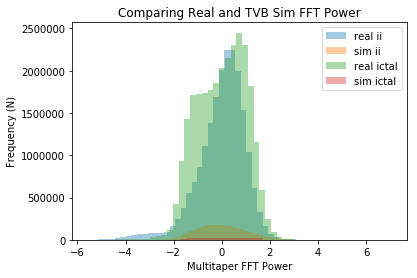

In [12]:
# show how to normalize data
realpower, simpower = sync_data(realdata, simdata, 'interictal')

realpower = np.abs(realpower)
simpower = np.abs(simpower)

print(realpower.shape)
print(simpower.shape)
simpower = standardize_power(simpower)
realpower = standardize_power(realpower)

plt.figure() # hist_kws=dict(alpha=1)
ax = sns.distplot(realpower.ravel(), kde=False, label='real ii', hist_kws=dict(alpha=0.4))
ax = sns.distplot(simpower.ravel(), kde=False, label='sim ii', hist_kws=dict(alpha=0.4))
ax.set(title='Comparing Real and TVB Sim FFT Power', xlabel='Multitaper FFT Power', ylabel='Frequency (N)')
# ax.set(title='Comparing Real and TVB Sim Morlet Power', xlabel='Morlet Wavelet Power', ylabel='Frequency (N)')

realpower, simpower = sync_data(realdata, simdata, typedata='ictal')
realpower = np.abs(realpower)
simpower = np.abs(simpower)

simpower = standardize_power(simpower)
realpower = standardize_power(realpower)

print(realpower.shape)
print(simpower.shape)

ax = sns.distplot(realpower.ravel(), kde=False, label='real ictal', hist_kws=dict(alpha=0.4))
ax = sns.distplot(simpower.ravel(), kde=False, label='sim ictal', hist_kws=dict(alpha=0.4))
ax.set(title='Comparing Real and TVB Sim FFT Power', xlabel='Multitaper FFT Power', ylabel='Frequency (N)')
# ax.set(title='Comparing Real and TVB Sim Morlet Power', xlabel='Morlet Wavelet Power', ylabel='Frequency (N)')

plt.legend()
plt.grid('off')
plt.savefig(os.path.join(figpath,'{}_normalized_fftpower.svg'.format(patient)), 
            format='svg', 
#             transparent=True,
            dpi=1200)
plt.show()

In [123]:
print(np.min(simpower.ravel()), np.max(simpower.ravel()))
print(np.min(realpower.ravel()), np.max(realpower.ravel()))
print(np.mean(simpower.ravel()), np.mean(realpower.ravel()))
print(np.std(simpower.ravel()), np.std(realpower.ravel()))

0.5249174591095209 10.340663174959
1.7095966442084288e-07 7.468443253890768
4.63440646785127 2.1726889566753207
0.6593634038475552 0.9711387581312458


## General Notes
Looks like the simulated power decomposition is a biased towards higher powers and also has less variability then the real power spectrum.

## Interictal
Also, overestimates mean and underestimates the variance

## Ictal
Also, overestimates mean and underestimates the variance

In [14]:
# compare using KS test
# show how to normalize data
realpower, simpower = sync_data(realdata, simdata, 'ictal')
realpower = np.abs(realpower)
simpower = np.abs(simpower)
print(realpower.shape)
print(simpower.shape)
simpower = standardize_power(simpower)
realpower = standardize_power(realpower)

simpower = simpower.ravel()
realpower = realpower.ravel()
# compare using KS
stat, pval = ks_2samp(simpower.ravel(), realpower.ravel())
print(stat, pval)

[2664.0, 29311.0] [14146.0]
(15,)
(15,)
85 200
0 4
(92, 2561, 115)
(92, 2501, 4)
0.056573865206897334 0.0


# Perform Sampling and Using KL Divergence

In [15]:
realpower = np.random.choice(realpower, size=simpower.shape, replace=False)

In [16]:
print(entropy(realpower, simpower))

inf


In [17]:
print(normalized_mutual_info_score(realpower, simpower))

1.0


# Load in Real SEEG FFT Image Transformed Data

In [148]:
realseeg_imgdir = '/Volumes/ADAM LI/pydata/output_fft/freqimg/fft/'
pat_imgdir = os.path.join(realseeg_imgdir, patient)

# get a list of all the datasets for this patient
filepaths = []
for root, dirs, files in os.walk(pat_imgdir):
    for file in files:
        if '.npz' in file:
            filepaths.append(os.path.join(root, file))
print(filepaths)

['/Volumes/ADAM LI/pydata/output_fft/freqimg/fft/id001_bt/BTcrisePavecGeneralisation_0007_fftmodel.npz', '/Volumes/ADAM LI/pydata/output_fft/freqimg/fft/id001_bt/BTcrise2appportable_0013_fftmodel.npz', '/Volumes/ADAM LI/pydata/output_fft/freqimg/fft/id001_bt/BTcrise1appportable_0006_fftmodel.npz', '/Volumes/ADAM LI/pydata/output_fft/freqimg/fft/id001_bt/BTcrisepartielle+preictalspiking_0009_fftmodel.npz']


In [152]:
for resultfile in filepaths:
    realdata = np.load(resultfile, encoding='latin1')
    metadata = simdata['metadata'].item()
    imagetensor = realdata['image_tensor']
    ylabels = 
    print(metadata.keys())
    print(realdata.keys())
    break

dict_keys(['ezregs', 'samplefreq', 'x0pz', 'epiparams', 'pzindices', 'patient', 'samplerate', 'ezindices', 'chanlabels', 'regions', 'offsettimes', 'onsettimes', 'gainmat', 'x0norm', 'stepsize', 'x0ez', 'pzregs', 'seeg_xyz', 'regions_centers', 'winsize', 'mtbandwidth', 'rawfilename'])
['image_tensor', 'metadata']


In [ ]:
print(image_tensor.shape)

# Load in Simulated SEEG FFT Image Transformed Data

In [5]:
simseeg_imgdir = '/Volumes/ADAM LI/'